## Regression Outline
We have a set of manually categorized FERC plants with which to test the sklearn Classifier that we're making. We'll also use them to test the regression analysis here. What does this dataset look like, how was it created?
* Pull FERC Plants table.
* Using a variety of search methods, to ensure that we get a wide variety of plants, identify sets of records in the FERC Form 1 Plants table that are comparable inter-year records.


For regressions, both OLS and sklearn approaches are explored.  Plant generation is normalized by using capacity factor.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np

import scipy
import pandas as pd
import statsmodels.api as sm
import sklearn
from sklearn import linear_model
from pudl import init, analysis, settings, output
import pudl.extract.ferc1
import pudl.transform.ferc1
import pudl.constants as pc
import pudl.output.pudltabl
import pudl.analysis.analysis
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [3]:
# For some reason these things don't stick if they're in the same cell as the
# %matplotlib inline call above, but if they're separate, they work fine.
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

In [4]:
pudl_out = pudl.output.pudltabl.PudlTabl()
ferc1_fuel = pudl_out.fuel_ferc1()
ferc1_steam = pudl_out.plants_steam_ferc1()
eia860_plants =  pudl.output.eia860.plants_eia860()
# eia923_plants =  pudl.output.eia923.plants_eia923()

In [5]:
ferc1_fuel.columns

Index(['report_year', 'utility_id_ferc1', 'utility_id_pudl',
       'utility_name_ferc1', 'plant_id_pudl', 'plant_id_ferc1', 'plant_name',
       'fuel_consumed_mmbtu', 'fuel_consumed_total_cost_mmbtu',
       'fuel_consumed_total_cost_unit', 'fuel_cost_per_mmbtu',
       'fuel_cost_per_mwh', 'fuel_cost_per_unit_burned',
       'fuel_cost_per_unit_delivered', 'fuel_mmbtu_per_mwh',
       'fuel_mmbtu_per_unit', 'fuel_qty_burned', 'fuel_type_code_pudl',
       'fuel_unit', 'record_id'],
      dtype='object')

In [6]:
# ferc1_fuel = pudl.analysis.analysis.primary_fuel_ferc1(ferc1_fuel)

## Side effort to calculate primary fuel type for ferc1 plants

In [7]:
# For each plant record in the plants table, we need to be able to assign
# a fraction of heat content for that plant that came from a particlar fuel
# for filtering purposes. There are different ways that we can aggregate that
# information -- e.g. plant_id_pudl, plant_id_ferc1, (utility_id_ferc1, plant_name)
def coal_fraction(fuel_df, gb_cols=['plant_id_pudl']):
    """
    Calculate the fraction of overall heat content from coal
    per year and per gb_cols, which can be:
      - [plant_id_pudl]
      - [plant_id_ferc1]
      - [utility_id_ferc1, plant_name]
    
    Assumes fuel_df is a fuel_ferc1 dataframe.
    Cannot currently work for arbitrary fuel_type becuase not all plants
    have records for all fuel types.
    """
    gb_cols1 = ['report_year'] + gb_cols
    
    # Total heat content across all fuel types
    total_mmbtu = (
        fuel_df.groupby(gb_cols1).
        agg({'fuel_consumed_mmbtu': sum}).
        reset_index().
        rename(columns={'fuel_consumed_mmbtu': 'total_mmbtu'})
    )
    
    # Same grouping... but also broken down by fuel type
    gb_cols2 = gb_cols1 + ['fuel_type_code_pudl']
    out_df = (
        fuel_df[fuel_df.fuel_type_code_pudl=='coal'].
        groupby(gb_cols2).
        agg({'fuel_consumed_mmbtu': sum}).
        reset_index().
        merge(total_mmbtu, how='left', on=gb_cols1).
        assign(coal_fraction=lambda x: x['fuel_consumed_mmbtu'] / x['total_mmbtu']).
        rename(columns={'fuel_consumed_mmbtu': 'coal_mmbtu'}).
        drop(['fuel_type_code_pudl'], axis=1)
    )
    return out_df

In [8]:
# Calculate total heat content of fuel by plant & year
fuel_consumed_mmbtu = (
    ferc1_fuel.loc[ferc1_fuel.report_year>=2012,:].
    groupby(['report_year', 'plant_id_pudl']).
    agg({'fuel_consumed_mmbtu': sum}).
    reset_index()
)

coal_fraction_by_plant_name = coal_fraction(ferc1_fuel.loc[ferc1_fuel.report_year>=2012,:], ['utility_id_ferc1', 'plant_name'])


In [9]:
coal_plants = coal_fraction_by_plant_name[coal_fraction_by_plant_name.coal_fraction >= 0.85] # returns 96.7% of records

In [10]:
coal_plants.columns

Index(['report_year', 'utility_id_ferc1', 'plant_name', 'coal_mmbtu',
       'total_mmbtu', 'coal_fraction'],
      dtype='object')

In [11]:
## This function replaced by coal_fraction function

# def ferc1_aggregate_by_fuel_type(df, fuels = ['gas', 'oil', 'coal']):
#     ''' 
#     Aggregate FERC 1 data by fuel type and plant per year.
    
#     Inputs: 
#     df is cleaned FERC 1 fuel table
#     fuels is list of fuels of interest to aggregate
    
#     Returns dataframe of aggregated fuel consumed and fuel costs'''
    
#     fuel_df = df[df['fuel_type_code_pudl'].isin(fuels)]
    
#     # We have two different ways of assessing the total cost of fuel given cost
#     # per unit delivered and cost per mmbtu. They *should* be the same, but we
#     # know they aren't always. Calculate both so we can compare both.
#     fuel_df['fuel_consumed_mmbtu'] = \
#         fuel_df['fuel_qty_burned'] * fuel_df['fuel_mmbtu_per_unit'] # same as total heat content
#     fuel_df['fuel_consumed_total_cost_mmbtu'] = \
#         fuel_df['fuel_cost_per_mmbtu'] * fuel_df['fuel_consumed_mmbtu']
#     fuel_df['fuel_consumed_total_cost_unit'] = \
#         fuel_df['fuel_cost_per_unit_burned'] * fuel_df['fuel_qty_burned']


#     # Group by fuel as well, so we get individual fuel totals.
#     cols_to_gb = ['plant_id_ferc1', 'report_year', 'fuel_type_code_pudl', 'plant_name', 'utility_id_ferc1']
#     cols=['fuel_consumed_mmbtu',
#                                  'fuel_consumed_total_cost_mmbtu',
#                                  'fuel_consumed_total_cost_unit']

#     fuel_df = fuel_df.groupby(cols_to_gb)[cols].sum()
#     fuel_df = fuel_df.reset_index()
    
#     # Group by plant, so we get total fuel use/cost.
#     cols_to_gb = ['plant_id_ferc1', 'report_year', 'plant_name', 'utility_id_ferc1']
#     cols=['fuel_consumed_mmbtu',
#                                  'fuel_consumed_total_cost_mmbtu',
#                                  'fuel_consumed_total_cost_unit'] 


#     fuel_df_plant = fuel_df.groupby(cols_to_gb)[cols].sum()
#     fuel_df_plant = fuel_df_plant.reset_index()
    
#     return fuel_df_plant

In [12]:
ferc1_fuel.columns

Index(['report_year', 'utility_id_ferc1', 'utility_id_pudl',
       'utility_name_ferc1', 'plant_id_pudl', 'plant_id_ferc1', 'plant_name',
       'fuel_consumed_mmbtu', 'fuel_consumed_total_cost_mmbtu',
       'fuel_consumed_total_cost_unit', 'fuel_cost_per_mmbtu',
       'fuel_cost_per_mwh', 'fuel_cost_per_unit_burned',
       'fuel_cost_per_unit_delivered', 'fuel_mmbtu_per_mwh',
       'fuel_mmbtu_per_unit', 'fuel_qty_burned', 'fuel_type_code_pudl',
       'fuel_unit', 'record_id'],
      dtype='object')

## Return to previous effort

In [13]:
## This function call replaced by coal fraction calculation
# fuel_df_plant = ferc1_aggregate_by_fuel_type(ferc1_fuel, fuels=['coal'])

In [14]:
new = pd.merge(ferc1_fuel, coal_plants, on=['plant_name', 'utility_id_ferc1', 'report_year'], how='right')


In [15]:
new.count()

report_year                       3286
utility_id_ferc1                  3286
utility_id_pudl                   3286
utility_name_ferc1                3286
plant_id_pudl                     3286
plant_id_ferc1                    3286
plant_name                        3286
fuel_consumed_mmbtu               3286
fuel_consumed_total_cost_mmbtu    3286
fuel_consumed_total_cost_unit     3286
fuel_cost_per_mmbtu               3286
fuel_cost_per_mwh                 3286
fuel_cost_per_unit_burned         3286
fuel_cost_per_unit_delivered      3286
fuel_mmbtu_per_mwh                3286
fuel_mmbtu_per_unit               3286
fuel_qty_burned                   3286
fuel_type_code_pudl               3279
fuel_unit                         3259
record_id                         3286
coal_mmbtu                        3286
total_mmbtu                       3286
coal_fraction                     3286
dtype: int64

In [16]:
ferc1_steam.head(1)

,report_year,utility_id_ferc1,utility_id_pudl,utility_name_ferc1,plant_id_pudl,plant_id_ferc1,plant_name,asset_retirement_cost,avg_num_employees,capacity_mw,capex_equipment,capex_land,capex_per_mw,capex_structures,capex_total,construction_type,construction_year,id,installation_year,net_generation_mwh,not_water_limited_capacity_mw,opex_allowances,opex_boiler,opex_coolants,opex_electric,opex_engineering,opex_fuel,opex_misc_power,opex_misc_steam,opex_operations,opex_per_mwh,opex_plants,opex_production_total,opex_rents,opex_steam,opex_steam_other,opex_structures,opex_transfer,peak_demand_mw,plant_capability_mw,plant_hours_connected_while_generating,plant_type,record_id,water_limited_capacity_mw
0,2004,1,7,AEP Generating Company,526,1,rockport unit 1 aeg,370055.0,0.0,650.0,519609333.0,6472089.0,941097.0,85261549.0,611713026.0,conventional,1984.0,1,1984.0,4863470.0,650.0,0.0,2674529.0,0.0,500806.0,515891.0,63145559.0,1087877.0,309521.0,619333.0,14.6,1299007.0,70860809.0,438.0,481592.0,0.0,226256.0,0.0,671.0,0.0,8360.0,steam,2004_1_0_1,650.0


In [17]:
new.head(8)

,report_year,utility_id_ferc1,utility_id_pudl,utility_name_ferc1,plant_id_pudl,plant_id_ferc1,plant_name,fuel_consumed_mmbtu,fuel_consumed_total_cost_mmbtu,fuel_consumed_total_cost_unit,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_mmbtu_per_mwh,fuel_mmbtu_per_unit,fuel_qty_burned,fuel_type_code_pudl,fuel_unit,record_id,coal_mmbtu,total_mmbtu,coal_fraction
0,2012,1,7,AEP Generating Company,526,3,rockport total aeg,9.199978e+07,2.023075e+08,2.022721e+08,2.199,22.0,39.364,39.174,9.806,17.904000,5138504.0,coal,ton,2012_1_0_7,9.199978e+07,9.208414e+07,0.999084
1,2012,1,7,AEP Generating Company,526,3,rockport total aeg,8.436413e+04,1.874149e+06,1.874166e+06,22.215,0.0,127.816,131.716,0.000,5.753538,14663.0,oil,bbl,2012_1_0_8,9.199978e+07,9.208414e+07,0.999084
2,2013,1,7,AEP Generating Company,526,3,rockport total aeg,7.696229e+07,2.014873e+08,2.015010e+08,2.618,25.0,46.148,46.242,9.831,17.626000,4366407.0,coal,ton,2013_1_0_7,7.696229e+07,7.706641e+07,0.998649
3,2013,1,7,AEP Generating Company,526,3,rockport total aeg,1.041231e+05,2.351515e+06,2.351540e+06,22.584,0.0,129.170,129.606,0.000,5.719476,18205.0,oil,bbl,2013_1_0_8,7.696229e+07,7.706641e+07,0.998649
4,2014,1,7,AEP Generating Company,526,3,rockport total aeg,8.010336e+07,2.106718e+08,2.106882e+08,2.630,25.0,46.744,46.236,9.589,17.772000,4507279.0,coal,ton,2014_1_0_7,8.010336e+07,8.021234e+07,0.998641
5,2014,1,7,AEP Generating Company,526,3,rockport total aeg,1.089744e+05,2.483635e+06,2.483658e+06,22.791,0.0,131.043,123.674,0.000,5.749716,18953.0,oil,bbl,2014_1_0_8,8.010336e+07,8.021234e+07,0.998641
6,2015,1,7,AEP Generating Company,526,3,rockport total aeg,6.151198e+07,1.572861e+08,1.572602e+08,2.557,25.0,45.277,44.747,9.909,17.710000,3473291.0,coal,ton,2015_1_0_7,6.151198e+07,6.165919e+07,0.997613
7,2015,1,7,AEP Generating Company,526,3,rockport total aeg,1.472068e+05,2.538582e+06,2.538543e+06,17.245,0.0,99.127,77.756,0.000,5.748246,25609.0,oil,bbl,2015_1_0_8,6.151198e+07,6.165919e+07,0.997613


In [18]:
# diff = fuel_df_plant.fuel_consumed_total_cost_mmbtu - fuel_df_plant.fuel_consumed_total_cost_unit
# Max difference in costs is on the order of 1e+9; median is 4e-1; 
# Could use this calculation comparison to eliminate, or further investigate, outliers.

In [19]:
out_df = pd.merge(new, ferc1_steam, on=['plant_id_ferc1', 'report_year', 'plant_name', 'utility_id_ferc1'])


In [20]:
out_df.columns

Index(['report_year', 'utility_id_ferc1', 'utility_id_pudl_x',
       'utility_name_ferc1_x', 'plant_id_pudl_x', 'plant_id_ferc1',
       'plant_name', 'fuel_consumed_mmbtu', 'fuel_consumed_total_cost_mmbtu',
       'fuel_consumed_total_cost_unit', 'fuel_cost_per_mmbtu',
       'fuel_cost_per_mwh', 'fuel_cost_per_unit_burned',
       'fuel_cost_per_unit_delivered', 'fuel_mmbtu_per_mwh',
       'fuel_mmbtu_per_unit', 'fuel_qty_burned', 'fuel_type_code_pudl',
       'fuel_unit', 'record_id_x', 'coal_mmbtu', 'total_mmbtu',
       'coal_fraction', 'utility_id_pudl_y', 'utility_name_ferc1_y',
       'plant_id_pudl_y', 'asset_retirement_cost', 'avg_num_employees',
       'capacity_mw', 'capex_equipment', 'capex_land', 'capex_per_mw',
       'capex_structures', 'capex_total', 'construction_type',
       'construction_year', 'id', 'installation_year', 'net_generation_mwh',
       'not_water_limited_capacity_mw', 'opex_allowances', 'opex_boiler',
       'opex_coolants', 'opex_electric', 'opex_e

In [21]:
out_df["heat_rate"] = (out_df.fuel_consumed_mmbtu / out_df.net_generation_mwh)
out_df['capacity_factor'] = (out_df['net_generation_mwh']/ (out_df['capacity_mw']*8760))

first_cols = [
    'report_year',
    'utility_id_ferc1',
    'plant_id_ferc1',
    'plant_name'
]

out_df = pudl.helpers.organize_cols(out_df, first_cols)

In [22]:
# Check to see if the 'tot_prdctn_expns' is equivalent to the non-fuel costs by summing non-fuel values
out_df["all_costs"] = (out_df.opex_allowances+out_df.opex_boiler+
                                  out_df.opex_coolants+
                         out_df.opex_electric+out_df.opex_engineering+
                                  out_df.opex_fuel+out_df.opex_misc_power+
                                  out_df.opex_misc_steam+
                        out_df.opex_operations+out_df.opex_plants+
                                  out_df.opex_rents+
                        out_df.opex_steam+out_df.opex_steam_other+
                                  out_df.opex_structures+
                        out_df.opex_transfer)

In [23]:
# Check to see if for all records the 'tot_prdctn_expns' approximately equals the sum from 'all_costs'
out_df['result'] = out_df['all_costs'].ge(out_df['opex_production_total']) | np.isclose(out_df['all_costs'], out_df['opex_production_total'], rtol=1e+1)

In [24]:
out_df.result.describe() # For all records, the costs are within $10. Confirms 'tot_prdctn_expsn' is all non-fuel costs

count     3286
unique       1
top       True
freq      3286
Name: result, dtype: object

In [25]:
# No need to retain these - have confirmed that 'opex_production_total' is sum of all other costs
out_df.drop(columns=['result','all_costs'], inplace=True)

In [26]:
# We can get non-fuel by subtracting opex_fuel
out_df['non_fuel_costs'] = (out_df.opex_production_total - out_df.opex_fuel)

In [27]:
out_df.installation_year = pd.to_numeric(out_df.installation_year, errors='coerce')
out_df.construction_year = pd.to_numeric(out_df.construction_year, errors='coerce')

In [28]:
# What types of fuel are included in the training data set?
out_df.plant_type.unique()

array(['steam', None, 'combustion_turbine', 'internal_combustion',
       'nuclear', 'combined_cycle'], dtype=object)

In [29]:
# All records
out_df_s = out_df[(out_df['plant_type'] == 'steam')]
# out_df_ct = out_df[(out_df['plant_type'] == 'combustion_turbine')] 
# out_df_cc = out_df[(out_df['plant_type'] == 'combined_cycle')] 
# out_df_ic = out_df[(out_df['plant_type'] == 'internal_combustion')]
# out_df_n = out_df[(out_df['plant_type'] == 'nuclear')] 
# out_df_pv = out_df[(out_df['plant_type'] == 'photovoltaic')] 

In [30]:
# Unique plants
steam_plants = out_df_s.sort_values('installation_year').drop_duplicates(subset=['capacity_mw', 'plant_name'], keep='last') # 1007 'plants'
# ct = out_df_ct.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 584 'plants'
# cc = out_df_cc.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 188 'plants'
# ic = out_df_ic.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 147 'plants'
# nuc = out_df_n.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 5 'plants'
# pv = out_df_pv.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 3 'plants'


In [31]:
# Remove null values for variables of interest, for purposes of histogram plotting
steam_plants = steam_plants[steam_plants.construction_year.notnull()]
steam_plants = steam_plants[steam_plants.installation_year.notnull()]
steam_plants = steam_plants[steam_plants.capacity_mw.notnull()]
steam_plants = steam_plants[steam_plants.heat_rate.notnull()]

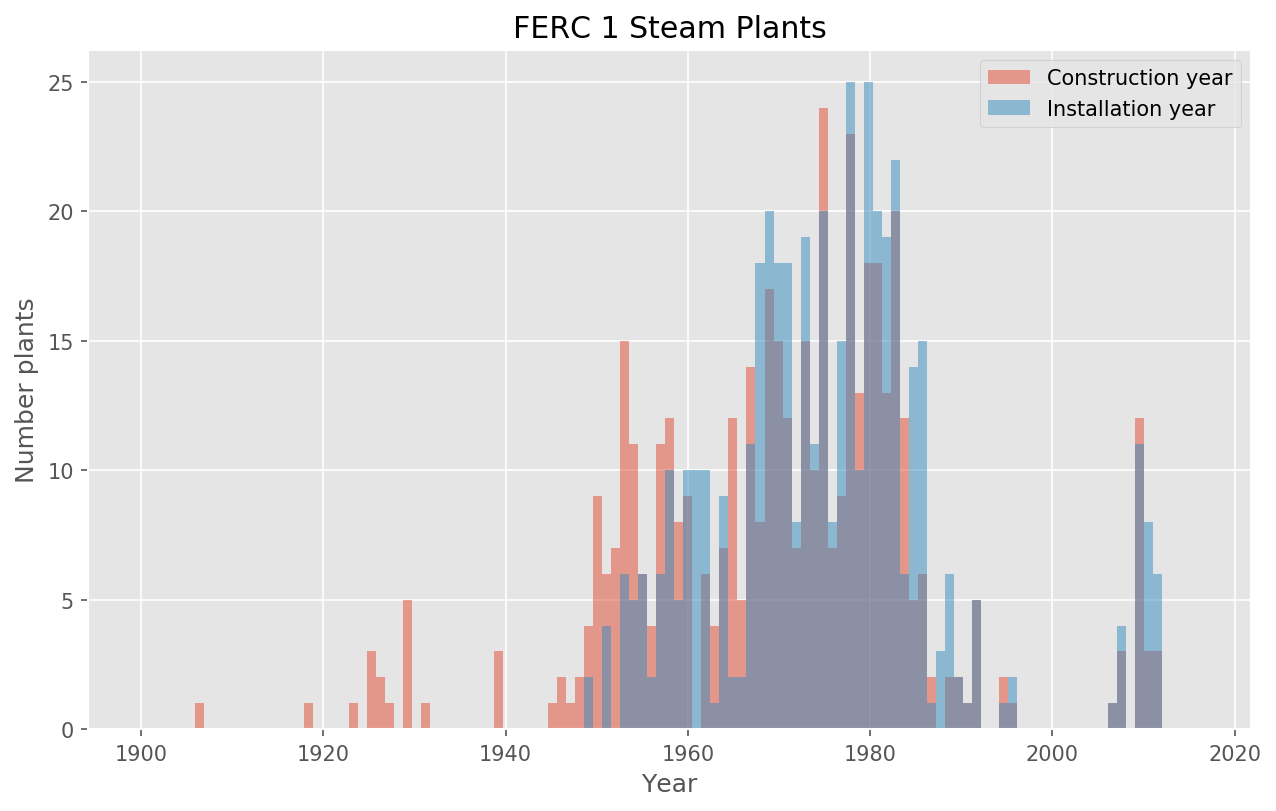

In [32]:
# Look at distribution of construction years vs. installation years.
fig = plt.figure()

plt.xlabel('Year')
plt.ylabel('Number plants')
plt.title('FERC 1 Steam Plants')

mpl.pyplot.hist(steam_plants.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
mpl.pyplot.hist(steam_plants.installation_year, bins = 117, range = [1900,2016], alpha=0.5, label='Installation year')
mpl.pyplot.legend(loc='upper right');

In [33]:
# fig = plt.figure()
# # ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
# #                    xticklabels=[], ylim=(-1.2, 1.2))
# plt.xlabel('Year')
# plt.ylabel('Number of plants')
# plt.title('FERC 1 Combustion Turbine Plants')

# mpl.pyplot.hist(ct.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
# mpl.pyplot.hist(ct.installation_year, bins = 117, range = [1900,2016], alpha=0.5, label='Installation year')
# mpl.pyplot.legend(loc='upper left');

In [34]:
# fig = plt.figure()
# # ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
# #                    xticklabels=[], ylim=(-1.2, 1.2))
# plt.xlabel('Year')
# plt.ylabel('Number of plants')
# plt.title('FERC 1 Combined Cycle Plants')

# mpl.pyplot.hist(cc.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
# mpl.pyplot.hist(cc.installation_year, bins = 117, range = [1900,2016], alpha=0.5, label='Installation year')
# mpl.pyplot.legend(loc='upper left');

In [35]:
# fig = plt.figure()
# # ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
# #                    xticklabels=[], ylim=(-1.2, 1.2))
# plt.xlabel('Year')
# plt.ylabel('Number of plants')
# plt.title('FERC 1 Internal Combustion Plants')

# mpl.pyplot.hist(ic.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
# mpl.pyplot.hist(ic.installation_year, bins = 117, range = [1900,2016], alpha=0.5, label='Installation year')
# mpl.pyplot.legend(loc='upper left');


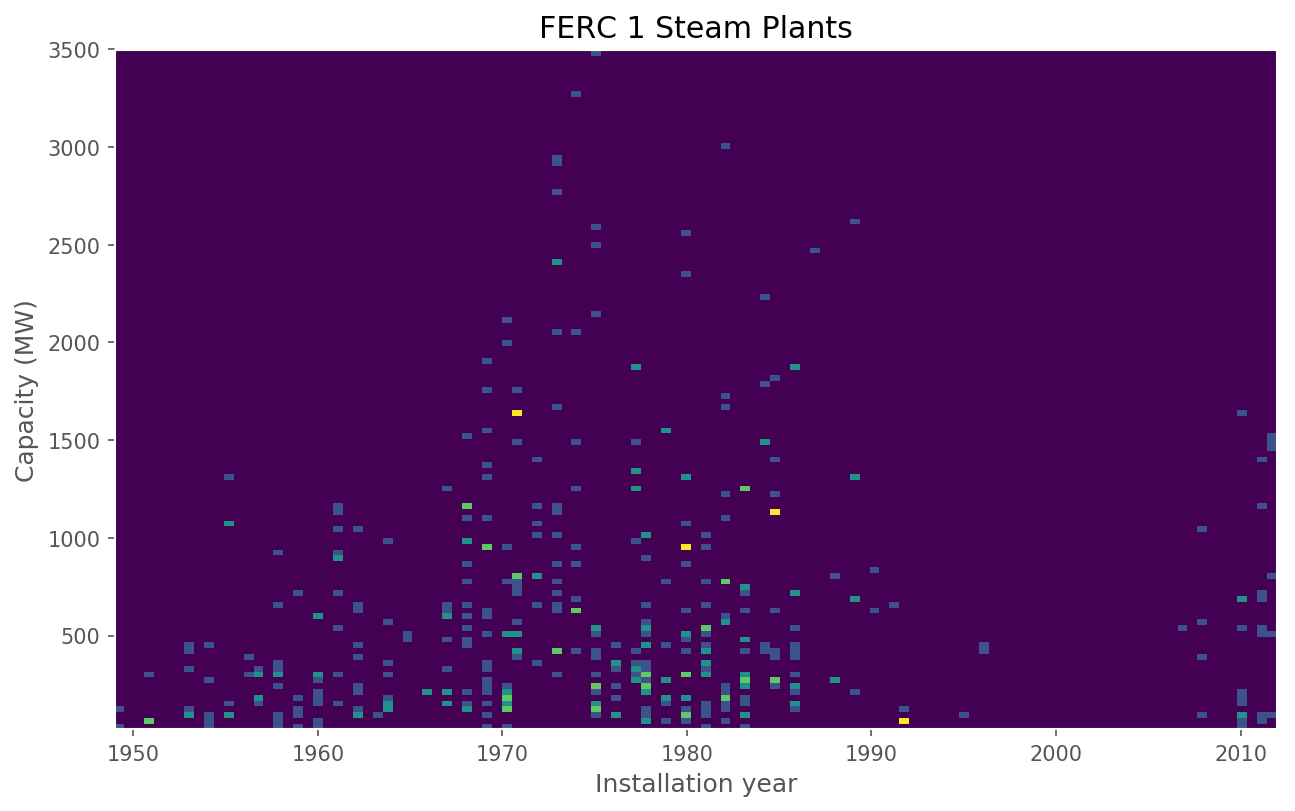

In [36]:
plt.xlabel('Installation year')
plt.ylabel('Capacity (MW)')
plt.title('FERC 1 Steam Plants')
# plt.legend()

mpl.pyplot.hist2d(steam_plants.installation_year, steam_plants.capacity_mw, bins=117);
#1940 and forward, up to 3K megawatts, just steam - natural groupings?
# install, constru, capacity, and HR then we should find groupings to work wtih.

In [37]:
def ferc1_record_subsetting(df, plant_type = 'steam', year_var = 'installation_year', 
                            bin1 = 1970, bin2 = 1987, new_var = 'new_var'):
    """ Subsets records by plant type and vintage. Creates new column for vintage.
    Input variables:
        'old' = year cutoff below which plants are considered 'old'
        'new' = year cutoff above which plants are considered 'new'
        'plant_type' = FERC 1 plant types, including: 'steam', 'combustion_turbine', 'internal_combustion', 'nuclear', 'combined_cycle', 'photovoltaic'
        'year_var' = either 'installation_year' or 'construction_year'
        
        Returns data frame with new column for vintage, and subset to the specified plant types.
        """
    
    out_df = df[(df['plant_type'] == plant_type)]
    out_df.loc[out_df[year_var] <= bin1,new_var] = 1
    out_df.loc[(out_df[year_var] > bin1) & (out_df[year_var] <= bin2), new_var] = 2
    out_df.loc[out_df[year_var] >= bin2, new_var] = 3
#     out_df.new_var = out_df.new_var.as_type(int)

    
    
    return out_df

In [38]:
### Still need to convert 'vintage' to a categorical variable for further use

In [39]:
new = ferc1_record_subsetting(out_df_s, new_var = 'vintage2')

In [40]:
new.head(2)

,report_year,utility_id_ferc1,plant_id_ferc1,plant_name,asset_retirement_cost,avg_num_employees,capacity_factor,capacity_mw,capex_equipment,capex_land,capex_per_mw,capex_structures,capex_total,coal_fraction,coal_mmbtu,construction_type,construction_year,fuel_consumed_mmbtu,fuel_consumed_total_cost_mmbtu,fuel_consumed_total_cost_unit,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_mmbtu_per_mwh,fuel_mmbtu_per_unit,fuel_qty_burned,fuel_type_code_pudl,...,opex_fuel,opex_misc_power,opex_misc_steam,opex_operations,opex_per_mwh,opex_plants,opex_production_total,opex_rents,opex_steam,opex_steam_other,opex_structures,opex_transfer,peak_demand_mw,plant_capability_mw,plant_hours_connected_while_generating,plant_id_pudl_x,plant_id_pudl_y,plant_type,record_id_x,record_id_y,total_mmbtu,utility_id_pudl_x,utility_id_pudl_y,utility_name_ferc1_x,utility_name_ferc1_y,water_limited_capacity_mw,non_fuel_costs,vintage2
0,2012,1,3,rockport total aeg,2576019.0,0.0,0.818239,1310.0,656230841.0,6547239.0,583390.2,98887065.0,764241164.0,0.999084,9.199978e+07,conventional,1984.0,9.199978e+07,2.023075e+08,2.022721e+08,2.199,22.0,39.364,39.174,9.806,17.904000,5138504.0,coal,...,204148097.0,3557644.0,985151.0,2529691.0,31.9,2119375.0,299544259.0,68287760.0,5835118.0,0.0,771157.0,0.0,1319.0,0.0,7915.0,526,526,steam,2012_1_0_7,2012_1_0_3,9.208414e+07,7,7,AEP Generating Company,AEP Generating Company,1308.0,95396162.0,3.0
1,2012,1,3,rockport total aeg,2576019.0,0.0,0.818239,1310.0,656230841.0,6547239.0,583390.2,98887065.0,764241164.0,0.999084,9.199978e+07,conventional,1984.0,8.436413e+04,1.874149e+06,1.874166e+06,22.215,0.0,127.816,131.716,0.000,5.753538,14663.0,oil,...,204148097.0,3557644.0,985151.0,2529691.0,31.9,2119375.0,299544259.0,68287760.0,5835118.0,0.0,771157.0,0.0,1319.0,0.0,7915.0,526,526,steam,2012_1_0_8,2012_1_0_3,9.208414e+07,7,7,AEP Generating Company,AEP Generating Company,1308.0,95396162.0,3.0


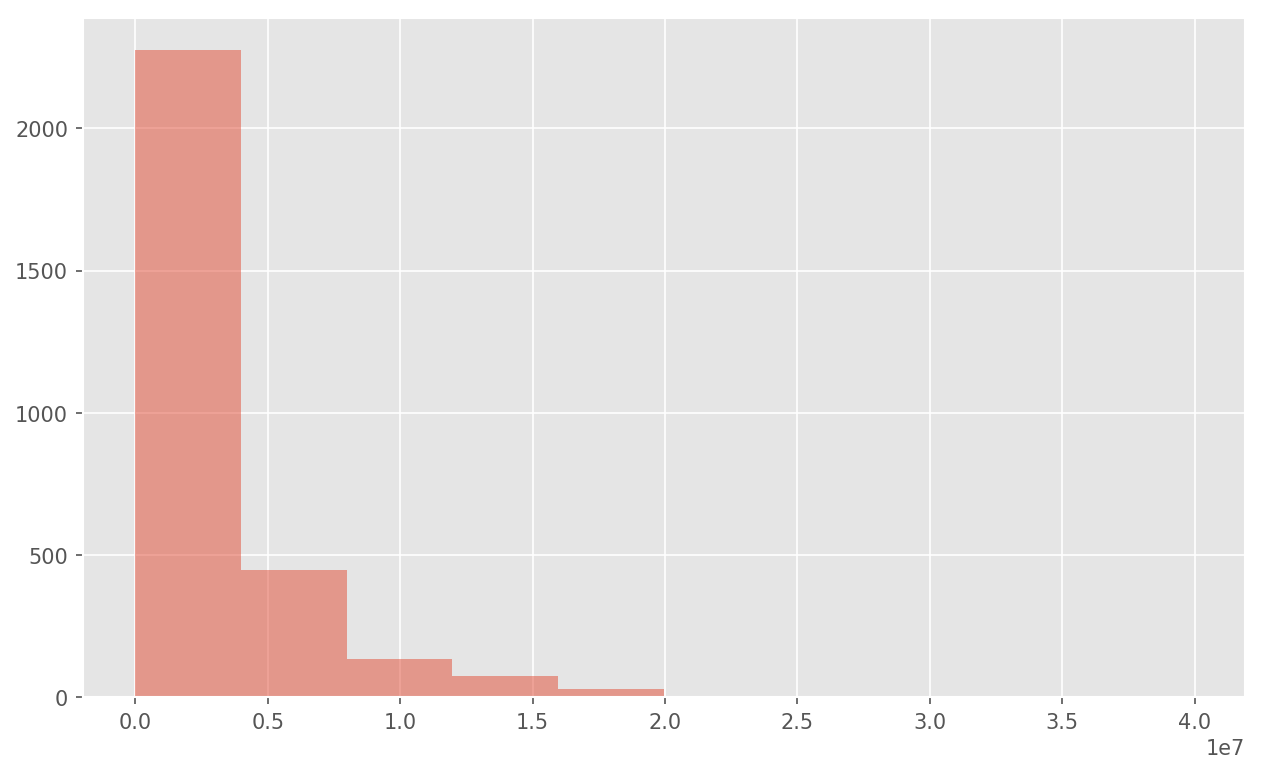

In [41]:
new.net_generation_mwh.hist(alpha=0.5, bins=10)

### Manual binning of construction year, installation year, plant capacity, and net generation

In [42]:
oldest = new.loc[(new['construction_year'] < 1956)]
older = new.loc[(new['construction_year'] >= 1946) & (new['construction_year']< 1956)]
mid = new.loc[(new['construction_year'] >= 1956) & (new['construction_year']< 1966)]
newer = new.loc[(new['construction_year'] >= 1966) & (new['construction_year']< 1986)]
newest = new.loc[new['construction_year'] >= 1986]

In [43]:
res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=oldest).fit()
# print(res.params)
print("Adj. R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

Adj. R-squared = 
0.778807770303498

Intercept             1.453108e+06
net_generation_mwh    6.660243e+00
capacity_mw           1.573394e+04
dtype: float64


In [44]:
res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=older).fit()
# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.8177036229450785

Intercept             2.488636e+06
net_generation_mwh    7.539107e+00
capacity_mw           1.060152e+04
dtype: float64


In [45]:
res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=mid).fit()
# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.7692049507118425

Intercept             1.852840e+06
net_generation_mwh    2.317142e+00
capacity_mw           2.809504e+04
dtype: float64


In [46]:
res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=newer).fit()
# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.7187678222739698

Intercept            -1.405750e+06
net_generation_mwh    3.207192e+00
capacity_mw           2.528797e+04
dtype: float64


In [47]:
res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=newest).fit()
# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.44103600720446123

Intercept            -3.304160e+07
net_generation_mwh   -1.837144e+00
capacity_mw           1.505955e+05
dtype: float64


In [48]:
oldest = new.loc[(new['installation_year'] < 1956)]
older = new.loc[(new['installation_year'] >= 1946) & (new['installation_year']< 1956)]
mid = new.loc[(new['installation_year'] >= 1956) & (new['installation_year']< 1966)]
newer = new.loc[(new['installation_year'] >= 1966) & (new['installation_year']< 1986)]
newest = new.loc[new['installation_year'] >= 1986]

In [49]:
res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=oldest).fit()
# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.9460791798704028

Intercept            -1.403107e+06
net_generation_mwh    8.077305e+00
capacity_mw           2.222663e+04
dtype: float64


In [50]:
res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=older).fit()
# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.9460791798704028

Intercept            -1.403107e+06
net_generation_mwh    8.077305e+00
capacity_mw           2.222663e+04
dtype: float64


In [51]:
res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=mid).fit()
# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.6271054871267788

Intercept             986938.534240
net_generation_mwh         4.658393
capacity_mw            21035.785408
dtype: float64


In [52]:
res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=newer).fit()
# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.802727572559653

Intercept             1.638099e+06
net_generation_mwh    9.887763e-01
capacity_mw           2.952565e+04
dtype: float64


In [53]:
res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=newest).fit()
# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.4975596761311375

Intercept            -6.861829e+06
net_generation_mwh   -1.001579e-01
capacity_mw           7.013000e+04
dtype: float64


In [54]:
new['construct_bin'] = 0
new.loc[(new['construction_year'] < 1956), 'construct_bin'] = 1
# new.loc[(new['construction_year'] >= 1946) & (new['construction_year']< 1956), 'construct_bin'] = 2
new.loc[(new['construction_year'] >= 1956) & (new['construction_year']< 1966), 'construct_bin'] = 3
new.loc[(new['construction_year'] >= 1966) & (new['construction_year']< 1986), 'construct_bin'] = 4
new.loc[new['construction_year'] >= 1986, 'construct_bin'] = 5
new.construct_bin = new.construct_bin.astype('category')

In [55]:
new['install_bin'] = 0
new.loc[(new['installation_year'] < 1955), 'install_bin'] = 1
# new.loc[(new['installation_year'] >= ) & (new['installation_year']< 1956), 'install_bin'] = 2
new.loc[(new['installation_year'] >= 1955) & (new['installation_year']< 1966), 'install_bin'] = 3
new.loc[(new['installation_year'] >= 1966) & (new['installation_year']< 1986), 'install_bin'] = 4
new.loc[new['installation_year'] >= 1986, 'install_bin'] = 5
new.install_bin = new.install_bin.astype('category')

## Regressions using binned/unbinned fields

In [56]:
# Some variables treated as categorical
res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw + C(construct_bin) +  C(install_bin)', data=new).fit()
# print(res.params)
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         non_fuel_costs   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     395.1
Date:                Mon, 25 Feb 2019   Prob (F-statistic):               0.00
Time:                        13:01:01   Log-Likelihood:                -54526.
No. Observations:                2962   AIC:                         1.091e+05
Df Residuals:                    2951   BIC:                         1.091e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -2.235e+

In [57]:
# Some variables treated as categorical
res = sm.OLS.from_formula(formula='non_fuel_costs ~ capacity_mw + C(construct_bin) +  C(install_bin)', data=new).fit()
# print(res.params)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         non_fuel_costs   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     435.4
Date:                Mon, 25 Feb 2019   Prob (F-statistic):               0.00
Time:                        13:01:01   Log-Likelihood:                -54533.
No. Observations:                2962   AIC:                         1.091e+05
Df Residuals:                    2952   BIC:                         1.091e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -2.298e+

In [58]:
# Some variables treated as categorical
res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + C(construct_bin) +  C(install_bin)', data=new).fit()
# print(res.params)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         non_fuel_costs   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     298.6
Date:                Mon, 25 Feb 2019   Prob (F-statistic):               0.00
Time:                        13:01:01   Log-Likelihood:                -54826.
No. Observations:                2962   AIC:                         1.097e+05
Df Residuals:                    2952   BIC:                         1.097e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -2.452e+

In [59]:
# All variables treated as continuous
res = sm.OLS.from_formula('non_fuel_costs ~ capacity_mw + net_generation_mwh + construction_year + installation_year', new).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         non_fuel_costs   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     896.5
Date:                Mon, 25 Feb 2019   Prob (F-statistic):               0.00
Time:                        13:01:01   Log-Likelihood:                -53854.
No. Observations:                2921   AIC:                         1.077e+05
Df Residuals:                    2916   BIC:                         1.077e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -5.387e+08    6.8

# Further/future regression exlorations

In [60]:
# Set up variables for OLS regression 

# X = new[["net_generation_mwh", "heat_rate"]]
X = new[["capacity_mw", "net_generation_mwh"]]
# X = new[["non_fuel_costs"]]
# X = new[["expns_fuel"]]

# y = new["opex_fuel"]
y = new[["non_fuel_costs"]]
# y = new[["net_generation_mwh"]]


X = sm.add_constant(X) ## add an intercept

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         non_fuel_costs   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     1751.
Date:                Mon, 25 Feb 2019   Prob (F-statistic):               0.00
Time:                        13:01:02   Log-Likelihood:                -54628.
No. Observations:                2962   AIC:                         1.093e+05
Df Residuals:                    2959   BIC:                         1.093e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.276e+05   6.46e+05     -0.352      0.725   -1.49e+06    1.04e+06
capacity_mw         3.618e+04   1410.956     25.644      0.000    3.34e+04    3.89e+04
net_generation_mwh     1.1487      0.266      4.317      0.000       0.627       1.670
==============================================================================
Omnibus:                     3938.254   Durbin-Watson:                   0.206
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           871615.943
Skew:                           7.423   Prob(JB):                         0.00
Kurtosis:                      85.716   Cond. No.                     6.40e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
# Use sklearn linear_model to fit the same regression
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
# print(predictions)[0:5]
lm.score(X,y)

0.5420547095525003

In [62]:
scipy.stats.linregress(out_df.net_generation_mwh, out_df.non_fuel_costs)

LinregressResult(slope=7.152369915579675, intercept=5696855.540322557, rvalue=0.6676340023152771, pvalue=0.0, stderr=0.13917736537635295)

In [63]:
# numpy.polyfit(ferc1_training_steam.net_generation, ferc1_training_steam.expns_fuel, 1)

In [64]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split

In [65]:
x = out_df.net_generation_mwh
y = out_df.non_fuel_costs
x_reshape = out_df_s.net_generation_mwh.values.reshape(-1,1)
y_reshape = out_df_s.non_fuel_costs.values.reshape(-1,1)

In [66]:
# intercept, slope, corr_coeff = plot_linear_regression(x_reshape, y_reshape)
# plt.show()


Text(0, 0.5, 'non-fuel costs')

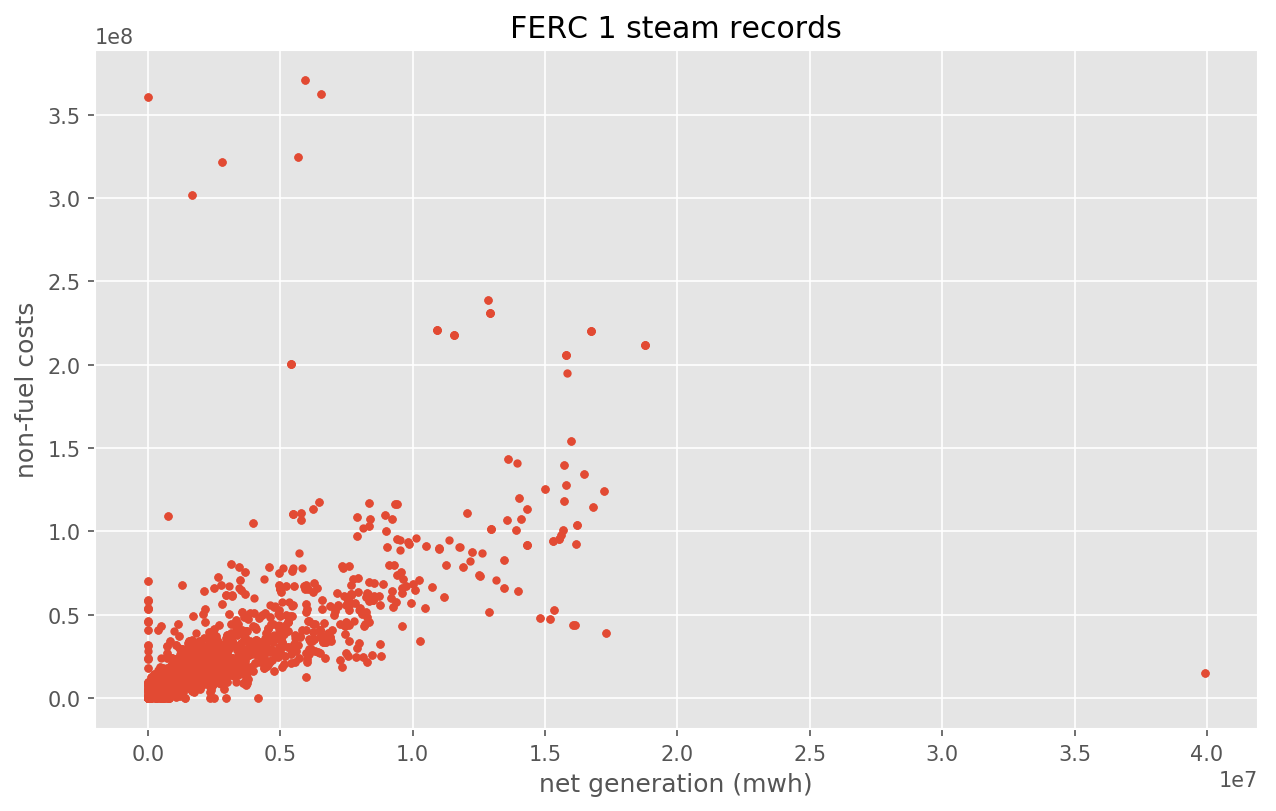

In [67]:
plt.plot(x,y,'.')
plt.title('FERC 1 steam records')
plt.xlabel('net generation (mwh)')
plt.ylabel('non-fuel costs')

In [68]:
### Exploration of other approaches...

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=0)

In [70]:
x_train= x_train.values.reshape(-1, 1)
y_train= y_train.values.reshape(-1, 1)
x_test = x_test.values.reshape(-1, 1)

In [71]:
ridge = Ridge(fit_intercept=True, alpha=0.5)

In [72]:
ridge.fit(x_reshape,y_reshape)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [73]:
sklearn.linear_model.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
# ferc1_training_steam.net_generation_mwh, ferc1_training_steam.non_fuel_costs)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [74]:
clf = sklearn.linear_model.Ridge(alpha=1)
clf = sklearn.linear_model.Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001)

clf.fit(x_reshape, y_reshape)
# Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [75]:
result = clf.fit(x_reshape, y_reshape, sample_weight=None)

In [76]:
clf.score(x_reshape,y_reshape)

0.4402832539372874

In [77]:
result.get_params()

{'alpha': 1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}